<a href="https://colab.research.google.com/github/sahasubhajit/Speech-Spoofing-/blob/main/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers
!pip install datasets
!pip install jiwer
!pip install umap-learn
!pip install eer

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from umap import UMAP
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,  PredefinedSplit
import matplotlib.pyplot as plt
from eer import eer, eer_tnt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
sns.set(style='white', context='poster')

In [9]:
def load_train_data(X_train, y_train):
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  return X_train, y_train

def load_validation_data(X_validation, y_validation):
  X_validation = np.array(X_validation)
  y_validation = np.array(y_validation)
  return X_validation, y_validation

def load_test_data(X_test, y_test):
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  return X_test, y_test


class MLModel:
    def __init__(self, model_type, use_supervised_umap=False, mapper=False):
        self.model_type = model_type
        self.use_supervised_umap = use_supervised_umap
        self.mapper = mapper

        if self.use_supervised_umap:
            self.umap = UMAP(n_neighbors=20, n_components=2)
            self.scaler = StandardScaler()
        if model_type == 'SVM':
            self.model = SVC()
            self.param_grid = {'C': [0.1, 1, 5], 'kernel': ['linear', 'rbf']}
        elif model_type == 'RandomForest':
            self.model = RandomForestClassifier()
            self.param_grid = {'n_estimators': [50, 75, 100]}
        elif model_type == 'KNN':
            self.model = KNeighborsClassifier()
            self.param_grid = {'n_neighbors': [3, 5, 7]}
        elif model_type == 'LogisticRegression':
            self.model = LogisticRegression()
            self.param_grid = {'C': [0.1, 1, 5]}
        elif model_type == 'NaiveBayes':
            self.model = GaussianNB()
            self.param_grid = {}
        elif model_type == 'XGBoost':
            self.model = xgb.XGBClassifier()
            self.param_grid = {'max_depth': [5, 10, 15], 'learning_rate': [0.1, 0.01]}
        elif model_type == 'DecisionTree':
            self.model = DecisionTreeClassifier()
            self.param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}
        else:
            print("Unknown model name!")


    def reduce_dimension(self, X_train, y_train, X_val, y_val, algo_name = 'UMAP', supervised = True):
      if algo_name == 'UMAP':
          umap = UMAP(n_neighbors=10, n_components=2)

          if supervised:
              # Train supervised UMAP on labeled data
              mapper = umap.fit(X_train, y_train)
              embedding = mapper.transform(X_val)
          else:
              # Use unsupervised UMAP on training data
              embedding = umap.fit_transform(X_val)

          # Visualize the projection on the validation data
          fig, ax = plt.subplots(figsize=(14, 10))
          # For simplicity, assuming that y_val has the same number of classes as y_train
          # You may need to adapt this if it's not the case
          classes = [1,0]
          colors = ['red', 'green']  # Adjust colors for more classes

          for i, class_label in enumerate(classes):
              class_indices = np.where(y_val == class_label)
              plt.scatter(embedding[class_indices, 0], embedding[class_indices, 1], s=10, c=colors[i], label=f'Class {class_label}')

          plt.legend()
          plt.title('Dimension reduction via UMAP with Validation Data')
          plt.show()

          return embedding



    def preprocess_input(self, X):
        if self.use_supervised_umap:
            pass
        return X

    def train(self, X_train, y_train, X_val, y_val):
        print("{} is training ...".format(self.model_type))
        # Create the test fold for PredefinedSplit
        train_indices = np.full(len(X_train), -1)  # -1 for training set
        val_indices = np.full(len(X_val), 0)  # 0 for validation set
        test_fold = np.concatenate((train_indices, val_indices))

        # Set up GridSearchCV to find the best number of trees using F1 score
        ps = PredefinedSplit(test_fold=test_fold)
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

        # Get the best model with the optimal number of trees
        best_model = grid_search.best_estimator_

        # Make predictions on the validation set with the best model
        y_pred = best_model.predict(X_val)


        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_val, y_pred)
        precision_val = precision_score(y_val, y_pred)
        recall_val = recall_score(y_val, y_pred)
        f1_val = f1_score(y_val, y_pred)
        print("Validation Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} (Grid search has made on f1 score only)".format(
            accuracy_val, precision_val, recall_val, f1_val))


        y_pred = best_model.predict(X_train)
        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_train, y_pred)
        precision_val = precision_score(y_train, y_pred)
        recall_val = recall_score(y_train, y_pred)
        f1_val = f1_score(y_train, y_pred)
        print("Training Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_val, precision_val, recall_val, f1_val))


        # Get the best parameters found by grid search
        print("Best parameters:", grid_search.best_params_)
        self.trained_model = best_model



    def test(self, X_test, y_test):

        print("Testing {} ...".format(self.model_type))

        if self.trained_model is None:
            print("Fit the model first.")
            return

        # Use the trained model to make predictions on the test set
        y_pred_test = self.trained_model.predict(X_test)

        # Calculate metrics on the test set
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_test = precision_score(y_test, y_pred_test)
        recall_test = recall_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)

        print("Test Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_test, precision_test, recall_test, f1_test))

        # Calculate EER for test set
        y_scores_test = self.trained_model.predict_proba(X_test)[:, 1]
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_scores_test)
        fnr_test = 1 - tpr_test
        eer_threshold_test = thresholds_test[np.nanargmin(np.absolute((fnr_test - fpr_test)))]
        eer_test = fpr_test[np.nanargmin(np.absolute((fnr_test - fpr_test)))]
        print("eer rate {} and threshold value {}".format(eer_test, eer_threshold_test))




        # Create an interactive ROC-AUC plot with Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=fpr_test, y=1-fnr_test, mode='lines', name='ROC curve'))
        fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, name='Random classifier')

        fig.update_layout(
            title='Receiver Operating Characteristic (ROC) Curve',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
        )

        fig.show()





        return fpr_test, fnr_test, eer_threshold_test






"""
    def evaluate(self, X, y):
        #if self.use_supervised_umap:
        #    X = self.preprocess_input(X)
        y_pred = self.model.predict(X)
        score = f1_score(y, y_pred)
        return score

    def grid_search(self, X_train, y_train, X_validation, y_validation):
        if not self.param_grid:
            print("No hyperparameters to tune.")
            return

        print(f"Grid search for {self.model_type}...")
        ps = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_validation))  # -1 for training, 0 for validation
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_validation)), np.hstack((y_train, y_validation)))

        print("Best parameters found:", grid_search.best_params_)
        self.model = grid_search.best_estimator_

        validation_accuracy = f1_score(y_validation, self.model.predict(X_validation))
        print(f"Validation set accuracy for {self.model_type}: {validation_accuracy}")
"""

'\n    def evaluate(self, X, y):\n        #if self.use_supervised_umap:\n        #    X = self.preprocess_input(X)\n        y_pred = self.model.predict(X)\n        score = f1_score(y, y_pred)\n        return score\n\n    def grid_search(self, X_train, y_train, X_validation, y_validation):\n        if not self.param_grid:\n            print("No hyperparameters to tune.")\n            return\n\n        print(f"Grid search for {self.model_type}...")\n        ps = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_validation))  # -1 for training, 0 for validation\n        grid_search = GridSearchCV(self.model, self.param_grid, scoring=\'f1\', cv=ps)\n        grid_search.fit(np.vstack((X_train, X_validation)), np.hstack((y_train, y_validation)))\n\n        print("Best parameters found:", grid_search.best_params_)\n        self.model = grid_search.best_estimator_\n\n        validation_accuracy = f1_score(y_validation, self.model.predict(X_validation))\n        print(f"Validation set

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/LA

/content/drive/MyDrive/LA


In [7]:
"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/train_1/train_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/train_2/train_2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/LA/train_3/train_3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/LA/train_4/train_4.csv")
df5 = pd.read_csv("/content/drive/MyDrive/LA/train_5/train_5.csv")
df = pd.concat([df1, df2, df3, df4, df5], axis = 0)
"""
df = pd.read_csv("/content/drive/MyDrive/LA/train.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
print(df.shape)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]

"""
df1 = pd.read_csv("/content/drive/MyDrive/LA/eval_1/eval_1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/LA/eval_2/eval_2.csv")
df = pd.concat([df1, df2], axis = 0)
"""


df = pd.read_csv("/content/drive/MyDrive/LA/dev.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
X_val = df.iloc[:, :-1]
y_val = df.iloc[:, -1]




df = pd.read_csv("/content/drive/MyDrive/LA/eval.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
X_test = df.iloc[:, :-1]
y_test = df.iloc[:, -1]
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(24215, 769)
(24215, 768) (24844, 768) (71237, 768) (24215,) (24844,) (71237,)


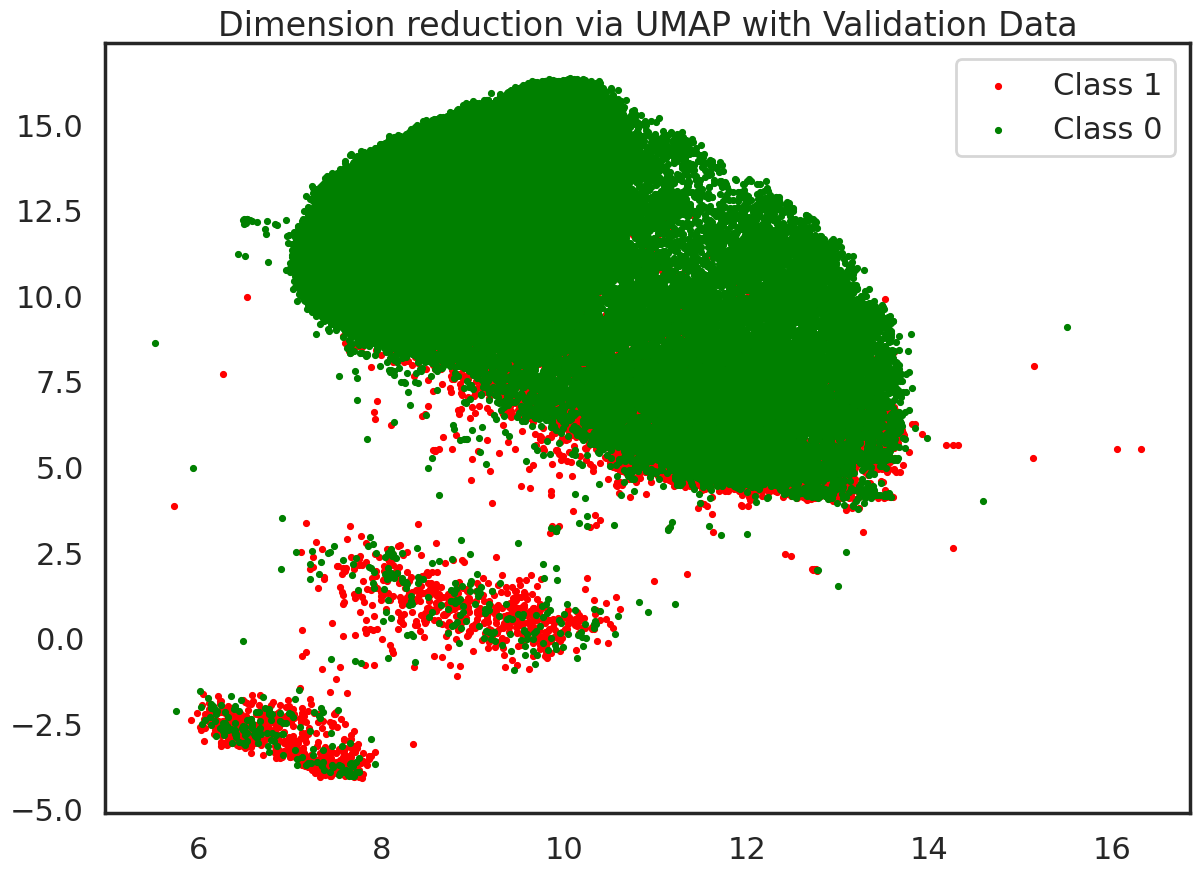

In [ ]:
ml_agent = MLModel('KNN')
#ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
#ml_agent.test(X_test, y_test)
X_projection = ml_agent.reduce_dimension(X_train, y_train, X_test, y_test)

In [ ]:
ml_agent = MLModel('KNN')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9257, Precision: 0.9092, Recall: 0.3065, F1: 0.4585 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9439, Precision: 0.9368, Recall: 0.4811, F1: 0.6357
Best parameters: {'n_neighbors': 3}
Testing KNN ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Test Set Metrics - Accuracy: 0.9102, Precision: 0.6617, Recall: 0.2665, F1: 0.3800


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



eer rate 0.06681068219529758


(array([0.        , 0.002442  , 0.01568517, 0.06681068, 1.        ]),
 array([1.        , 0.93283481, 0.73351462, 0.38830727, 0.        ]),
 0.3333333333333333)

In [ ]:
ml_agent = MLModel('RandomForest')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

RandomForest is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9999, Precision: 1.0000, Recall: 0.9988, F1: 0.9994 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Training Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Best parameters: {'n_estimators': 75}
Testing RandomForest ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Test Set Metrics - Accuracy: 0.9239, Precision: 0.8153, Recall: 0.3396, F1: 0.4795


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



eer rate 0.13122632353401584


(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.56538618e-05, 6.26154472e-05, 7.82693090e-05,
        1.25230894e-04, 1.72192480e-04, 2.19154065e-04, 3.13077236e-04,
        4.38308131e-04, 5.00923578e-04, 6.10500611e-04, 8.14000814e-04,
        9.86193294e-04, 1.15838577e-03, 1.31492439e-03, 1.64365549e-03,
        1.98804045e-03, 2.33242541e-03, 2.66115651e-03, 3.11511850e-03,
        3.66300366e-03, 4.19523496e-03, 5.05619736e-03, 5.83889045e-03,
        6.69985285e-03, 7.87389249e-03, 8.86008578e-03, 1.01593563e-02,
        1.16777809e-02, 1.33370903e-02, 1.51372844e-02, 1.71879403e-02,
        1.94420964e-02, 2.16649447e-02, 2.45296015e-02, 2.74099120e-02,
        2.99614915e-02, 3.28731098e-02, 3.63013055e-02, 4.00269246e-02,
        4.41751980e-02, 4.87304718e-02, 5.35205535e-02, 5.87802511e-02,
        6.45565261e-02, 7.01293009e-02, 7.68917692e-02, 8.41238534e-02,
        9.18725149e-02, 1.00216023e-01, 1.09796187e-01, 1.200807

In [ ]:
ml_agent = MLModel('XGBoost')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

XGBoost is training ...
Validation Set Metrics - Accuracy: 0.9489, Precision: 0.9271, Recall: 0.5443, F1: 0.6860 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9574, Precision: 0.9371, Recall: 0.6232, F1: 0.7486
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
Testing XGBoost ...
Test Set Metrics - Accuracy: 0.9302, Precision: 0.7736, Recall: 0.4582, F1: 0.5755
eer rate 0.10422341191571961


(array([0.        , 0.        , 0.        , ..., 0.98408002, 0.98411133,
        1.        ]),
 array([1.        , 0.99986404, 0.99374575, ..., 0.        , 0.        ,
        0.        ]),
 0.101242505)

In [ ]:
ml_agent = MLModel('NaiveBayes')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
fpr, fnr, eer_threshold_test = ml_agent.test(X_test, y_test)

NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.7568, Precision: 0.2770, Recall: 0.8516, F1: 0.4180 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.7480, Precision: 0.2654, Recall: 0.8356, F1: 0.4029
Best parameters: {}
Testing NaiveBayes ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Test Set Metrics - Accuracy: 0.8704, Precision: 0.4355, Recall: 0.8619, F1: 0.5786


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



eer rate 0.13261951723490184 and threshold value 0.005290010794560163


In [10]:
ml_agent = MLModel('DecisionTree')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9313, Precision: 0.7583, Recall: 0.4851, F1: 0.5917 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9375, Precision: 0.7725, Recall: 0.5461, F1: 0.6399
Best parameters: {'criterion': 'entropy', 'max_depth': 10}
Testing DecisionTree ...
Test Set Metrics - Accuracy: 0.9094, Precision: 0.6027, Recall: 0.3603, F1: 0.4510
eer rate 0.14362418208572056 and threshold value 0.03215434083601286


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



(array([0.        , 0.01103597, 0.0113334 , 0.01159951, 0.01181867,
        0.01189693, 0.0119752 , 0.01205347, 0.0123822 , 0.0125857 ,
        0.01278921, 0.01285182, 0.01311794, 0.01325882, 0.01383801,
        0.01394759, 0.01411978, 0.01493378, 0.01505902, 0.01615479,
        0.01674963, 0.0176419 , 0.01776713, 0.0178454 , 0.0180489 ,
        0.0184246 , 0.01956733, 0.02009956, 0.02117968, 0.02138318,
        0.02163364, 0.02244764, 0.02302683, 0.02312075, 0.02323033,
        0.02337122, 0.02387214, 0.02484268, 0.02518706, 0.02542187,
        0.02600106, 0.02723772, 0.0273473 , 0.02791084, 0.02820826,
        0.02831784, 0.02914749, 0.02921011, 0.02967972, 0.03107292,
        0.03199649, 0.03245046, 0.03465765, 0.03501769, 0.03515857,
        0.03534642, 0.03554992, 0.03583169, 0.03735011, 0.03752231,
        0.03846154, 0.03852415, 0.04002692, 0.04016781, 0.04242197,
        0.04489528, 0.0449892 , 0.04597539, 0.04622585, 0.04998278,
        0.05096897, 0.05129771, 0.05247174, 0.05

In [ ]:
ml_agent = MLModel('LogisticRegression')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

LogisticRegression is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Validation Set Metrics - Accuracy: 0.9288, Precision: 0.7278, Recall: 0.4878, F1: 0.5841 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9338, Precision: 0.7461, Recall: 0.5298, F1: 0.6197
Best parameters: {'C': 5}
Testing LogisticRegression ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Test Set Metrics - Accuracy: 0.9341, Precision: 0.7482, Recall: 0.5447, F1: 0.6304
eer rate 0.11563507717353871 and threshold value 0.10268536269036004


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



(array([0.        , 0.        , 0.        , ..., 0.86644125, 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99864038e-01, 9.92658056e-01, ...,
        1.35961931e-04, 1.35961931e-04, 0.00000000e+00]),
 0.10268536269036004)

In [ ]:
ml_agent = MLModel('SVM')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

SVM is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Validation Set Metrics - Accuracy: 0.9391, Precision: 0.8294, Recall: 0.5114, F1: 0.6327 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Training Set Metrics - Accuracy: 0.9459, Precision: 0.8386, Recall: 0.5802, F1: 0.6859
Best parameters: {'C': 5, 'kernel': 'linear'}
Testing SVM ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Test Set Metrics - Accuracy: 0.9373, Precision: 0.7646, Recall: 0.5675, F1: 0.6515


AttributeError: ignored